### Installation des dépendances

In [ ]:
%pip install numpy
%pip install opencv-python
%pip install -U matplotlib
%pip install -U scikit-image
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as py
from numpy import linalg as LA
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import os
import time

# Transformée de KL

### Lecture des fichiers images

In [87]:
def plotImage(image, type):
    figure = py.figure(figsize = (10,10))
    imageout = np.clip(image,0,255)
    imageout= imageout.astype(type)
    py.imshow(imageout, cmap='gray')
    py.show()

C:\Users\loicn\AppData\Local\Temp\ipykernel_34632\1820860134.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(imageOriginale, imageCompressee)


qualité de compression RGB : pour l'image kodim01.png [(0.00040148379554623214, -26.02749183891269)]
qualité de compression YUV : pour l'image kodim01.png [(-0.00045207111110746087, -29.70035493708533)]


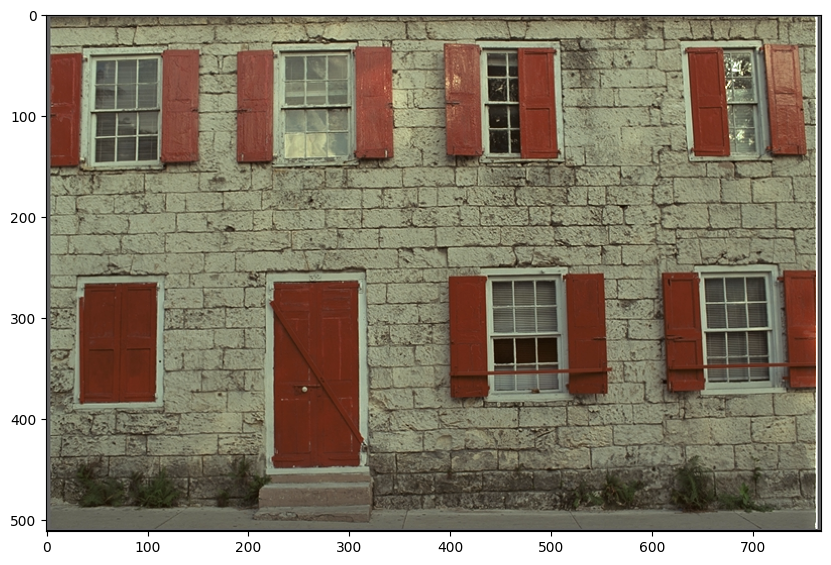

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


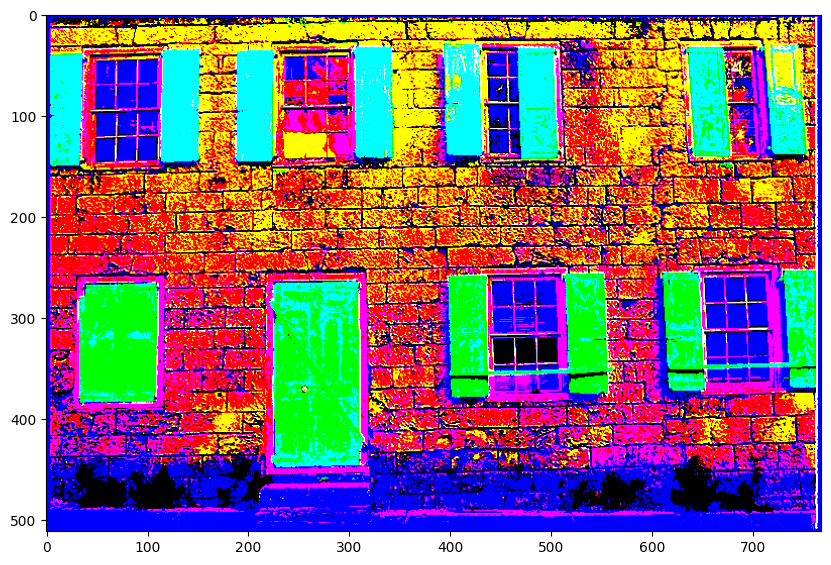

In [161]:

# Read image
dataPath = "/data/"
currDirectory = os.getcwd()
fileList = os.listdir(currDirectory + dataPath)
quantificateur = [[8,8,8], [8,8,4], [8,8,0], [8,4,0]]
qualiteCompressionRGB = []
qualiteCompressionYUV = []

for file in fileList:
    imagePath = currDirectory + dataPath + file
    img = py.imread(imagePath)
    
    if img is not None:
        YUVimage = cv.cvtColor(img, cv.COLOR_RGB2YUV)
        for q in quantificateur:
            imageKLTransforme = compression(img, q)
            imageYUVKLTransforme = compression(YUVimage, q)
            qualiteCompressionRGB.append(qualiteCompression(img, imageKLTransforme))
            qualiteCompressionYUV.append(qualiteCompression(YUVimage, imageYUVKLTransforme))
            break
            
        print("qualité de compression RGB : pour l'image " + file, qualiteCompressionRGB)
        qualiteCompressionRGB = []
        print("qualité de compression YUV : pour l'image " + file, qualiteCompressionYUV)
        qualiteCompressionYUV = []
        plotImage(img, 'double')
        plotImage(imageKLTransforme, 'double')
        break
    
   

## Question 2
### Implémentation de la transformée de KL 
### Quantification et recomposition de l'image

In [159]:
def compression(image, quantificateur: list):
    # Calcul de la moyenne
    sommeR = 0.0 
    sommeG = 0.0 
    sommeB = 0.0 
    for i in range(len(image)):
        for j in range(len(image[0])):
            sommeR=sommeR+image[i][j][0]
            sommeG=sommeG+image[i][j][1]
            sommeB=sommeB+image[i][j][2]
    nbPixels = len(image)*len(image[0])        
    MoyR= sommeR / nbPixels
    MoyG= sommeG / nbPixels
    MoyB= sommeB / nbPixels
    
    # calcul de la matrice de covariance
    covRGB = np.zeros((3,3), dtype = "double")
    for i in range(len(image)):
        for j in range(len(image[0])):
            vecTemp=[[image[i][j][0] - MoyR], [image[i][j][1]] - MoyG, [image[i][j][2] - MoyB]]
            vecProdTemp = np.dot(vecTemp,np.transpose(vecTemp))
            covRGB = np.add(covRGB,vecProdTemp)
    covRGB = covRGB / nbPixels  
    
    # Calcul des valeurs propres et vecteurs propres
    eigval, eigvec = LA.eig(covRGB)
    eigvec = np.transpose(eigvec)
    
    imageKL = np.copy(image)

    vecMoy = [[MoyR], [MoyG], [MoyB]]

    for i in range(len(image)):
        for j in range(len(image[0])):
            vecTemp = [[image[i][j][0]], [image[i][j][1]], [image[i][j][2]]]
            # a=Mb
            imageKL[i][j][:] = np.reshape(np.dot(eigvec, np.subtract(vecTemp, vecMoy)), (3))

    # Quantification
    imageKLQuantifie = np.copy(imageKL)
    K, L, W = imageKL[:,:,0], imageKL[:,:,1], imageKL[:,:,2]
    max_list = [np.max(K), np.max(L), np.max(W)]    
    for i in range(len(imageKL)):
        for j in range(len(imageKL[0])):
            for k in range(3):
                facteurQuantification = max_list[k] / math.pow(2, max(quantificateur[k]-1, 1))
                imageKLQuantifie[i][j][k] = math.floor(imageKL[i][j][k] / facteurQuantification)
    
    # convertir image KL quantifiée en image RGB
    imageReconvertie = np.copy(imageKLQuantifie)
    for i in range(len(imageKLQuantifie)):
        for j in range(len(imageKLQuantifie[0])):
            vecTemp = np.reshape(imageKLQuantifie[i][j], (3, 1))
            # Annuler la transformation KL
            imageReconvertie[i][j][:] = np.add(np.dot(np.linalg.inv(eigvec), vecTemp), vecMoy).flatten()
            # imageReconvertie[i][j][:] = np.reshape(np.dot(np.transpose(eigvec), imageKLQuantifie[i][j][:]) + vecMoy, (3))
                
    
    return imageKLQuantifie  

In [151]:
def qualiteCompression(imageOriginale, imageCompressee):
    imageOriginale = np.dot(imageOriginale[:,:], [0.299, 0.587, 0.114])
    imageOriginale = imageOriginale.astype('double')
    imageCompressee = np.dot(imageCompressee[:,:], [0.299, 0.587, 0.114])
    imageCompressee = imageCompressee.astype('int8')
    psnr = peak_signal_noise_ratio(imageOriginale, imageCompressee)
    ssim = structural_similarity(imageOriginale, imageCompressee, data_range=img.max() - img.min())
    return ssim, psnr